# Cambio Relativo en las Series Históricas

Se estudia el cambio relativo producido en el año 2020 respecto a la media de los 2013-2019. Esta comparación se realiza entre los mismos días del año, realizando primero la media del periodo 2013-2019.

$$
RC_i (\%)  = 100 \cdot \frac{C_{i, 2013-2019} - C_{i, 2020}}{C_{i, 2020}}
$$

donde $C_i$ es la concentración del contaminante en el día $i$ del año y el valor $C_{i, 2013-2019}$ se obtiene de la siguiente manera:

$$
C_{i, 2013-2019} = \overline{C_{i, j}} 
$$
con $j = \{2013, 2014, ..., 2019\}$

In [1]:
library(tidyverse)
library(ggplot2)

setwd("~/Repositories/AirQualityCOVID/")
source("src/Analysis/functions.R")

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=5,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
html.variable <- list("no" = "NO",
                      "no2" = "NO<sub>2</sub>",
                      "o3" = "O<sub>3</sub>",
                      "pm10" = "PM10",
                      "pm2.5" = "PM2.5"
                     )
r.variable <- c("no" = expression(NO),
                "no2" = expression(NO[2]),
                "o3" = expression(O[3]),
                "pm10" = expression(PM10),
                "pm2.5" = expression(PM2.5)
               )

In [4]:
periods <- list(
            # Prelockdown
            "pre lockdown" = lubridate::ymd("2020-01-01"),

            # lockdown
            lockdown = lubridate::ymd("2020-03-14"),
            #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

            # poslockdown
            fases = lubridate::ymd("2020-05-01"),
            normalidad = lubridate::ymd("2020-06-21"),

            # New lockdown
            new.lockdown = lubridate::ymd("2020-10-25"),
            end.year = lubridate::ymd("2020-12-31")
        )
    
   

In [5]:
load("data/data_AQ.rda")

data_AQ <- data_AQ %>%
            openair::timeAverage(avg.time = "day", 
                                 type = c("variable", "site"))

old <- data_AQ %>% 
        filter(lubridate::year(date) < 2020) %>% 
        select(date, site, variable, value)
lubridate::year(old$date) <- 2020

old.mean <- old %>%
                group_by(date, variable, site) %>%
                summarise(value = mean(value, na.rm=T)) %>%
                rename(previous.years = value)

`summarise()` has grouped output by 'date', 'variable'. You can override using the `.groups` argument.



In [6]:
results <- merge(old.mean,
                 data_AQ %>%
                        filter(lubridate::year(date) == 2020) %>% 
                        select(date, site, variable, value) %>%
                        rename(last.year = value),
                 by = c("date", "variable", "site"),
                 all.y = T, all.x=F
                ) %>%
            sep.periods(periods) %>%
            mutate(diff = relative.change(last.year,
                                          previous.years))

In [7]:
change <- results %>%
            group_by(periods, variable, site) %>%
            summarise(mean = mean(diff, na.rm=T),
                      std = sd(diff, na.rm=T))

`summarise()` has grouped output by 'periods', 'variable'. You can override using the `.groups` argument.



In [8]:
change.municipios <- group.municipio(change) %>%
            data.frame %>%
            mutate_if(is.factor, as.character)

`summarise()` has grouped output by 'variable', 'Municipio'. You can override using the `.groups` argument.



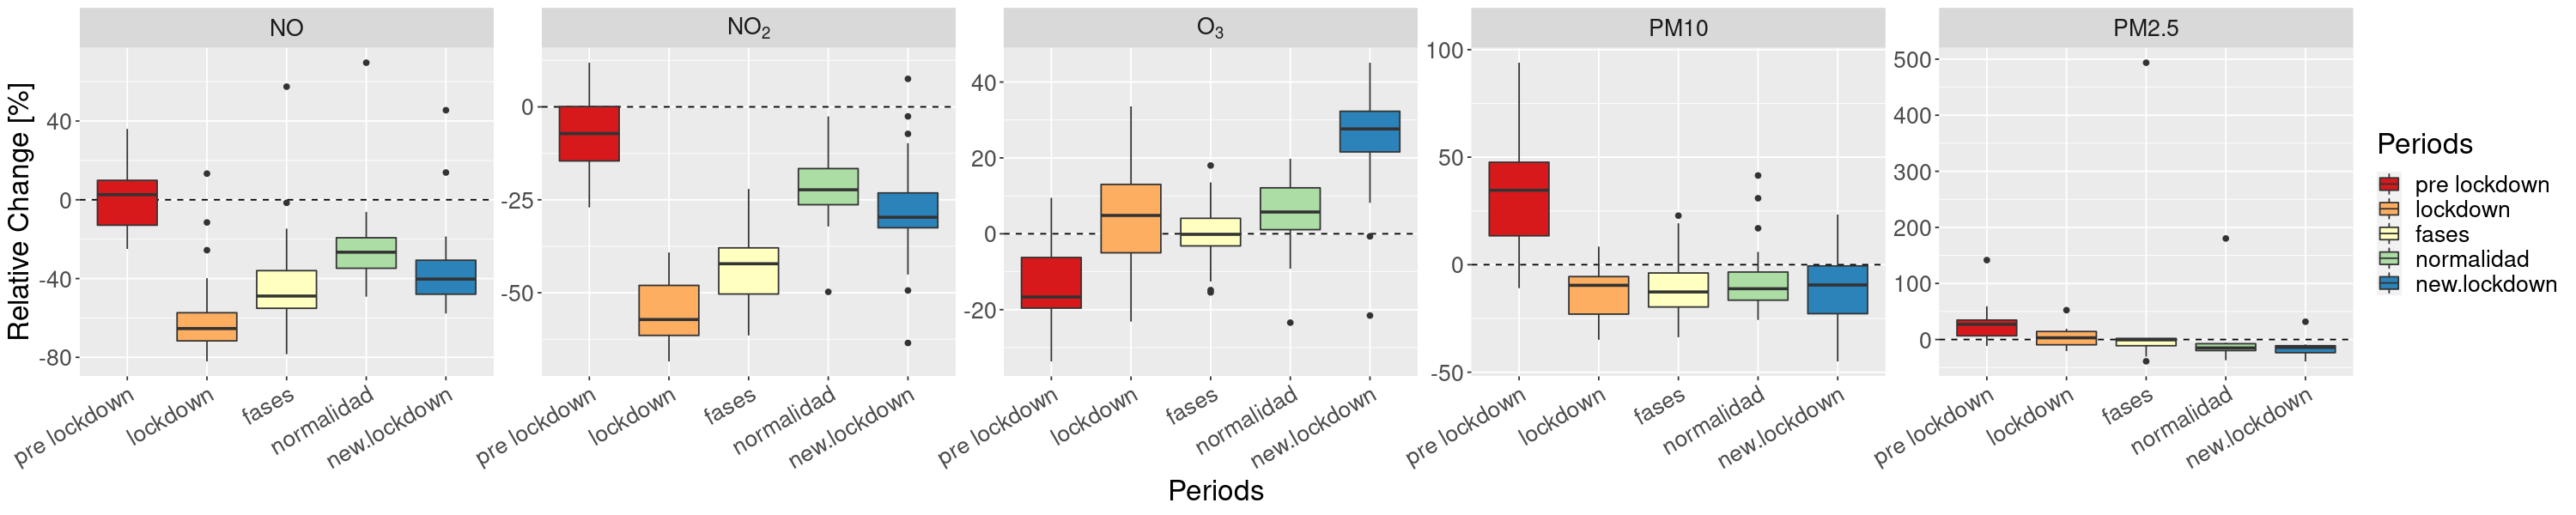

In [9]:
plot.df <- change.municipios

plot.df$periods <- factor(plot.df$periods,
                          levels = names(periods),
                          ordered = TRUE)
plot.df$variable <- factor(plot.df$variable, 
                           labels=r.variable)

ggplot(plot.df) +
    geom_hline(yintercept=0, linetype="dashed", color = "black") +
    geom_boxplot(aes(x=periods, y=mean, fill=periods)) + 
    theme(text = element_text(size=20),
          axis.text.x = element_text(angle=30, hjust=1)
         ) +
    scale_y_continuous(name="Relative Change [%]") +
    scale_x_discrete(name="Periods")+
    scale_fill_brewer(name="Periods", palette="Spectral") +
    facet_wrap(~variable, ncol=5, scale="free_y", 
               labeller = labeller(variable=label_parsed))

In [10]:
ggsave(last_plot(), filename="Plots/Results/vs_Observations/boxplot.png", width=10, height=8)

In [11]:
cleaned.df <- data.frame()
outlier.df <- data.frame()

for (pr in levels(as.factor(change.municipios$periods))) {
    for (pll in levels(as.factor(change.municipios$variable))) {
        dat.rw <- change.municipios %>%
                    filter(periods == pr,
                           variable == pll
                          )
        
        outlier <- boxplot.stats(dat.rw$mean)$out
        
        if (length(outlier) > 0) {
            in.position <- which(dat.rw$mean %in% outlier)
            
            cleaned.df <- rbind(cleaned.df,
                                dat.rw[-in.position, ])
            outlier.df <- rbind(outlier.df,
                                dat.rw[in.position, ])
        } else {
            cleaned.df <- rbind(cleaned.df,
                                dat.rw)
        }
    }
}

In [12]:
write.csv(outlier.df, 
          "data/Results/vs_Observations/outliers.csv",
          row.names=FALSE)

outlier.df %>% 
    filter(
           variable == "no2",
           #periods == "lockdown"
          ) %>%
    select(-latitude, -longitude)

,variable,Municipio,periods,mean
,<chr>,<chr>,<chr>,<dbl>
4,no2,Almera,new.lockdown,-7.265695
18,no2,Marbella,new.lockdown,-49.382771
19,no2,Mlaga,new.lockdown,7.527115
26,no2,Santander,new.lockdown,-63.508220
331,no2,Zaragoza,new.lockdown,-2.564352
28,no2,Santander,normalidad,-49.757026


In [13]:
mean.change <- cleaned.df %>% 
                    group_by(periods, variable) %>%
                    summarise(Mean = mean(mean, na.rm=T),
                              Median = median(mean, na.rm=T),
                              Q3 = quantile(mean, na.rm = T, 0.75),
                              Q1 = quantile(mean, na.rm = T, 0.25),
                              IQR = Q3-Q1
                             )
write_csv(mean.change,
          "data/Results/vs_Observations/change_stats.csv")

mean.change %>%
    filter(variable == "no2",
           #periods == "lockdown"
          )

`summarise()` has grouped output by 'periods'. You can override using the `.groups` argument.



periods,variable,Mean,Median,Q3,Q1,IQR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fases,no2,-42.630748,-42.197728,-37.92399559,-50.34084,12.416847
lockdown,no2,-55.369222,-57.203559,-48.01815523,-61.47344,13.455288
new.lockdown,no2,-28.281920,-29.748185,-24.56016619,-32.02563,7.465466
normalidad,no2,-20.765563,-22.283058,-16.59570935,-26.07467,9.478958
pre lockdown,no2,-7.643851,-7.180526,0.08609797,-14.54330,14.629393


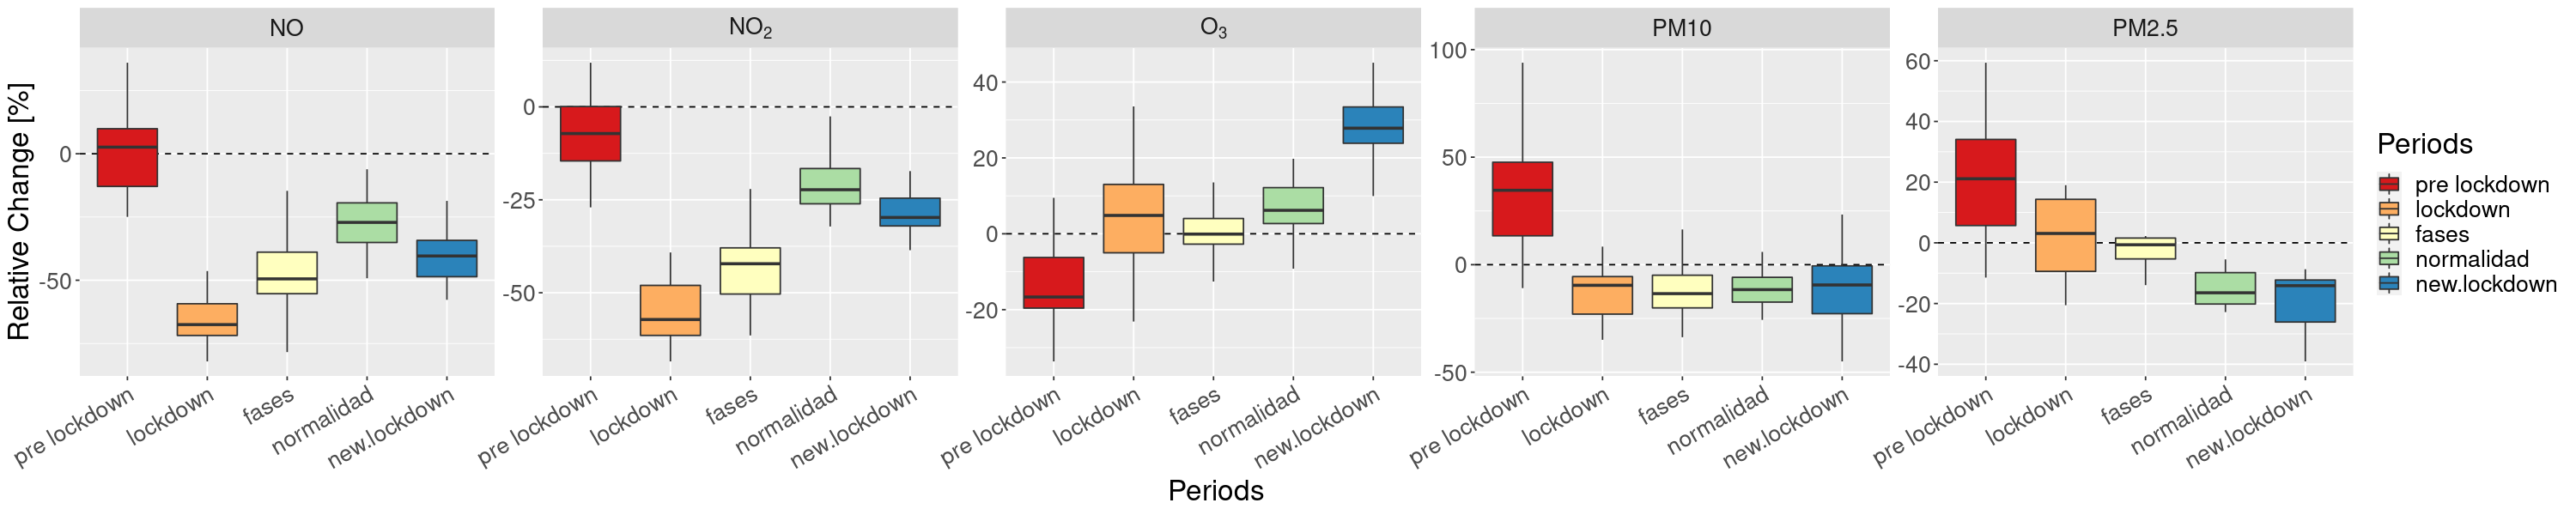

In [14]:
plot.df <- cleaned.df

plot.df$periods <- factor(plot.df$periods,
                          levels = names(periods),
                          ordered = TRUE)
plot.df$variable <- factor(plot.df$variable, 
                           labels=r.variable)

ggplot(plot.df) +
    geom_hline(yintercept=0, linetype="dashed", color = "black") +
    geom_boxplot(aes(x=periods, y=mean, fill=periods),outlier.shape = NA) + 
    theme(text = element_text(size=20),
          axis.text.x = element_text(angle=30, hjust=1)
         ) +
    scale_y_continuous(name="Relative Change [%]") +
    scale_x_discrete(name="Periods")+
    #scale_fill_discrete(name="Periods") +
    scale_fill_brewer(name="Periods", palette="Spectral") +
    facet_wrap(~variable, ncol=5, scale="free_y", 
               labeller = labeller(variable=label_parsed))

In [15]:
ggsave(last_plot(), filename="Plots/Results/vs_Observations/cleanded_boxplot.png", width=10, height=8)

---

In [16]:
library(leaflet)
library(leaflet.extras)
library(htmlwidgets)
library(htmltools)

In [17]:
variable <- "no2"

In [18]:
rr <- tags$div(HTML(paste(
    "<h3>", html.variable[[variable]],"</h3>"))
 ) 

beatCol <- colorNumeric(palette = "Spectral", #'RdYlGn',
                        domain = c(min(cleaned.df$mean, na.rm=T), 
                                   -min(cleaned.df$mean, na.rm=T)),
                        na.color = "transparent",
                        reverse = T,
                        
                       )

map <- leaflet(cleaned.df,
               options = leafletOptions(minZoom = 5, 
                                        maxZoom = 9)) %>%
            addControl(rr, position = "topright")  %>%
            addProviderTiles(providers$CartoDB.Positron)%>% 
            #addTiles() %>% # Add default OpenStreetMap map tiles
            addLayersControl(position="bottomleft", 
                             baseGroups = names(periods)[-6],
                             options = layersControlOptions(
                                         collapsed = FALSE
                                         )
                            )%>% 
            addCircleMarkers(~longitude, 
                             ~latitude, 
                             color=~beatCol(mean),
                             radius=10,
                             fillOpacity=0.9,
                             stroke=FALSE,
                             group=~periods,
                             popup = paste(cleaned.df$Municipio, ": ",
                                           trunc(cleaned.df$mean), "%", sep="")
                            )%>%
            addLegend("topleft", 
                       pal = beatCol, 
                       values = ~mean,
                       title = "Relative Change %",
                       labFormat = labelFormat(suffix = "%"),
                       opacity = 1,
                       )

map

Warning message in beatCol(mean):
"Some values were outside the color scale and will be treated as NA"
Warning message in beatCol(mean):
"Some values were outside the color scale and will be treated as NA"
Warning message in pal(c(r[1], cuts, r[2])):
"Some values were outside the color scale and will be treated as NA"


HTML widgets cannot be represented in plain text (need html)

In [19]:
library(htmlwidgets)
saveWidget(map, file=paste("~/Repositories/AirQualityCOVID/",
                           "Plots/Results/vs_Observations/",
                           variable, "-change_map.html", sep=""))